# Obtaining a frequency domain transfer function from a spatial kernel

## 1. A Basic Low Pass Filter Example

Here we try to implement the example mentioned in class with a low pass filter (say the gaussian one). Recall the major steps (note that we handle the filter consistently with the image in the first 4 steps), and this somewhat merge the steps of Page 82 in lecture 3's slides:

1. Given an input image $f(x,y)$ of size $M \times N$, obtain the padding parameters $P$ and $Q$. Similarly, we select a real low pass spatial filter $h(x,y)$ with size $C \times D$. Typically, $P = 2M$ and $Q = 2N$, as the kernel size will not exceeds the size of the image, i.e. $M \geq C$ and $N \geq D$, and hence it satisfies $P \geq M + C - 1$ and $Q \geq N + D - 1$. Here the $h$ is real because we want $f \star h$ to be real given that $f$ is real.

2. Form a padded image, $f_p(x,y)$ of size $P \times Q$ by appending the necessary number of zeros to $f(x,y)$. Similarly, we pad the filter to get $h_p(x,y)$. Specially, we might pad leading zeros to the filter to recover the parity (evenness or oddness) of the filter. Then, we may pad zeros around rather than behind the filter, and if the original filter is even or odd while we pad it evenly (i.e. the number of zeros add in row/column is symmetric on both sides), we can claim that it's still even or odd (shown in section about Symmetry Properties in the textbook, to be mentioned later).

3. Multiply $f_p(x,y)$ by $(-1)^{x+y}$ to center its transform. Do the same thing for the filter.

4. Compute the DFT, $F_p(u,v)$ of the image from step 3. Also do that for the filter and get $H_p(u,v)$.

5. If $h_p(x,y)$ is even, drop the imaginary part of $H_p(u,v)$; if $h_p(x,y)$ is odd, drop the real part of $H_p(u,v)$; otherwise no need to do the correction (Optional).

6. Form the product $G(u,v) = H(u,v)F(u,v)$ using array multiplication 

7. Obtain the processed image $g_p(x,y) = \{real [ \mathcal{F}^{-1}[G(u,v)]] \}(-1)^{x+y}$, where the real part is selected in order to ignore parasitic complex components resulting from computational inaccuracies

8. Obtain the final processed result, $g(x,y)$, by extracting the $M \times N$ region from the top, left quadrant of $g_p(x,y)$

9. If the filter is padded around rather than padded using zeros after it, we need to roll the image, and the shift distance in row and column equals that distance between the pad-around filter and the pad-after filter, except for a negative sign (Optional, if the filter is padded commonly).

Below we implement a function to check whether a function is numerically even or odd (the definition is of even and odd are the same except that you regard $\hat{x}=(x,y)$ as a vector for the input, where $-\hat{x} = (-x, -y)$, and we have $f(-\hat{x})=f(\hat{x})$ for even function with $f(-\hat{x})=-f(\hat{x})$ for odd function).

However, this is almost correct but not fully correct. It's mainly because the counter-intuitive setting in the discrete case.

By checking the definition in parity in section 4.6.4 Symmetry Properties on Page 239 of the textbook, Edition 3 (or Page 243, Edition 4), we shall see that the evenness and oddness are defined on the even part and the odd part of the function:

$$
f(x,y) = f_e(x,y) + f_o(x,y)
$$

where the even part $f_e(x,y)$ and the odd part $f_o(x,y)$ are defined as

$$
f_e(x,y) \triangleq \frac{f(x,y) + f(-x, -y)}{2} \\
f_o(x,y) \triangleq \frac{f(x,y) - f(-x, -y)}{2}
$$

We say the function is even when its odd part equals zero, and even when its even part equals zero. This seems to follow our definition. However, in the discrete case, the definition of even and odd becomes:

$$
f_e(x,y) = f_e(M-x, N-y) \\
f_o(x,y) = -f_o(M-x, N-y)
$$

Here we can see that $f_o(0,0) = 0$; and $f_o(M/2, N/2)$ if $M \mod 2 = 0$ and $N \mod 2 = 0$ for a even function. We can also see that it doesn't require $f(0, y), \forall y$ and $f(x, 0), \forall x$, to have any property for a even function.

Hence, we can fetch the first element (with all-zero index), and see whether it's 0 first, as a necessary condition for the odd function. If there is only one element and it's 0, this would be a even and odd function, else it'd be even. When there are more than one elements, we make slices starting from 1 in any dimension, and divided the flattened array into two parts, the first half part and the second half part. We reverse the second half part here. If the remaining array size can not be exactly divided by 2, there will be one element at the center, which doesn't belong to the first half or the second half. This one being zero is also a necessary condition for the function to be odd when it exists. Then we can check whether the first half element-wise equals the second half. If so, with the other necessary condition of being odd, we can claimed that it's odd. Otherwise, we then check whether they are element-wisely complementary, i.e. the sign is the only difference. If so, the function should be even, or else we can only say that it's neither even or odd.

Here we implement a intuitive function `check_even_odd_center` with the original intuitive definition which is wrong, but it provides the inspiration that can be utilized, while `check_even_odd_1d` and `check_even_odd_2d` are correct for the 1-D and 2-D case.

In [75]:
import numpy as np
# Note: below is a incorrect version that consider the center of the matrix as f(0,0). It's intuitive but it's incorrect.
def check_even_odd_center(x: np.ndarray)->int:
    '''
    Returns
    ----------------
    0:  even and odd
    1:  odd
    2:  even
    3:  not even or odd
    '''
    x = x.flatten()
    s = x.size
    if s == 0:
        raise ValueError('The input should not be empty')
    elif s == 1:
        if x[0] == 0:
            return 0
        else:
            return 2
    elif s % 2 == 0:
        m = s // 2
        l = x[:m]
        r = np.flip(x[m:])
        if np.all(l==r):
            return 2
        elif np.all(l==-r):
            return 1
        else:
            return 3
    else:
        m = (s - 1) // 2
        l = x[:m]
        r = np.flip(x[m+1:])
        if np.all(l==r):
            return 2
        elif np.all(l==-r) and x[m] == 0:
            return 1
        else:
            return 3

# This is the correct version to use for 1-d case
def check_even_odd_1d(x: np.ndarray)->int:
    '''
    Returns
    ----------------
    0:  even and odd
    1:  odd
    2:  even
    3:  not even or odd
    '''
    s = x.size
    if s == 0:
        raise ValueError('The input should not be empty')
    elif s == 1:
        if x[0] == 0:
            return 0
        else:
            return 2
    elif s % 2 == 0:
        m = s // 2
        l = x[1:m]
        r = np.flip(x[m+1:])
        if x[0] == 0 and x[m] == 0 and np.all(l==-r):
            return 1
        elif np.all(l==r):
            return 2
        else:
            return 3
    else:
        m = s // 2
        l = x[1:m+1]
        r = np.flip(x[m+1:])
        if x[0] == 0 and np.all(l==-r):
            return 1
        elif np.all(l==r):
            return 2
        else:
            return 3 

def check_even_odd_2d(x: np.ndarray)->int:
    '''
    Returns
    ----------------
    0:  even and odd
    1:  odd
    2:  even
    3:  not even or odd
    '''
    s = x.size
    M, N = x.shape
    if s == 0:              # shape of np.array([[]]) is (1,0)
        raise ValueError('The input should not be empty')
    elif s == 1:
        if x[0,0] == 0:
            return 0
        else:
            return 2
    elif M % 2 == 0 and N % 2 == 0:
        m = M // 2
        n = N // 2
        xt = x[1:,1:].flatten()
        mm = (m-1)*(N-1)+(n-1)
        l = xt[:mm]
        r = np.flip(xt[mm+1:])
        if x[0,0] == 0 and x[m,n] == 0 and np.all(l==-r):
            return 1
        elif np.all(l==r):
            return 2
        else:
            return 3
    else:
        m = M // 2
        n = N // 2
        xt = x[1:,1:].flatten()
        if M % 2 == 0 and N % 2 != 0:
            mm = (m-1)*(N-1)+(n-1) + 1
        else:
            mm = m*(N-1)
        l = xt[:mm]
        r = np.flip(xt[mm:])
        if x[0,0] == 0 and np.all(l==-r):
            return 1
        elif np.all(l==r):
            return 2
        else:
            return 3

k1 = np.array([[1, 2, 1],
               [2, 4, 2],
               [1, 2, 1]])
k2 = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])
k3 = np.array([[-1, 3, 1],
               [-2, 4, 2],
               [-1, 2, 6]])

print('wrong conclusion:', check_even_odd_center(k1))
print('wrong conclusion:', check_even_odd_center(k2))
print('wrong conclusion:', check_even_odd_center(k3))

print('actual conclusion:', check_even_odd_2d(k1))
print('actual conclusion:', check_even_odd_2d(k2))
print('actual conclusion:', check_even_odd_2d(k3))

a = np.array([2,  1,  1,  1])               # even

b = np.array([0, -1,  0,  1])               # odd

c = np.array([[0,  0,  0,  0,  0,  0],      # even
              [0,  0,  0,  0,  0,  0],
              [0,  0, -1,  0,  1,  0],
              [0,  0, -2,  0,  2,  0],
              [0,  0, -1,  0,  1,  0],
              [0,  0,  0,  0,  0,  0]])

d = np.array([[0,  0,  0,  0,  0],          # odd
              [0,  0,  0,  0,  0],
              [0,  2, -1, -1,  2],
              [0,  0,  0,  0,  0]])

e = np.array([[1]])                         # even

f = np.array([[0]])                         # even and odd

g = np.array([[0,  0,  0,  0,  0],
              [0,  1,  2,  3,  4],
              [0,  2,  1,  1, -2],
              [0, -2,  1,  1,  2],
              [0,  4,  3,  2,  1]])         # even

h = np.array([[0,  0,  0],
              [0,  1,  2],
              [0,  2,  1],
              [0, -1, -2],
              [0, -2, -1]])                 # odd

i = np.array([[-3,  0,  0],
              [ 0,  1,  2],
              [ 0,  2,  1],
              [ 0, -1, -2],
              [ 0, -2, -1]])                # not odd or even

print(check_even_odd_1d(a))
print(check_even_odd_1d(b))
print(check_even_odd_2d(c))
print(check_even_odd_2d(d))
print(check_even_odd_2d(e))
print(check_even_odd_2d(f))
print(check_even_odd_2d(g))
print(check_even_odd_2d(h))
print(check_even_odd_2d(i))

wrong conclusion: 2
wrong conclusion: 1
wrong conclusion: 3
actual conclusion: 3
actual conclusion: 3
actual conclusion: 3
2
1
1
2
2
0
2
1
3


Now we can extend it to the n-dimensional case, using the process we mentioned above:

In [76]:
def check_even_odd_inner(x: np.ndarray)->int:
    '''
    Returns
    ----------------
    1:  odd
    2:  even
    3:  not even or odd
    4:  empty
    '''
    s = x.size  # x.flat doesn't have size
    x = x.flat
    if s == 0:
        return 4        # different from the center function
    elif s == 1:
        if x[0] == 0:
            return 1    # different from the center function
        else:
            return 2
    elif s % 2 == 0:
        m = s // 2
        l = x[:m]
        r = np.flip(x[m:])
        if np.all(l==r):
            return 2
        elif np.all(l==-r):
            return 1
        else:
            return 3
    else:
        m = (s - 1) // 2
        l = x[:m]
        r = np.flip(x[m+1:])
        if np.all(l==r):
            return 2
        elif np.all(l==-r) and x[m] == 0:
            return 1
        else:
            return 3

def check_even_odd_nd(x: np.ndarray)->int:
    '''
    Returns
    ----------------
    0:  even and odd
    1:  odd
    2:  even
    3:  not even or odd
    '''
    x = np.squeeze(x)
    s = x.size
    dim = x.ndim
    if s == 0:
        raise ValueError('The input should not be empty')
    else:
        x0 = x.flat[0]
        if s == 1:
            if x0 == 0:
                return 0
            else:
                return 2
        else:
            idx_inner = tuple([slice(1,None)] * dim)
            xc = x[idx_inner]
            i = check_even_odd_inner(xc)
            if i == 3:
                return 3
            if (i == 1 or i == 4):
                if x0 == 0:
                    return 1
                else:
                    return 3
            if i == 2:
                return 2

print(check_even_odd_nd(a))
print(check_even_odd_nd(b))
print(check_even_odd_nd(c))
print(check_even_odd_nd(d))
print(check_even_odd_nd(e))
print(check_even_odd_nd(f))
print(check_even_odd_nd(g))
print(check_even_odd_nd(h))
print(check_even_odd_nd(i))

2
1
1
2
2
0
2
1
3


This is the function that add leading zeros to a filter, and we may use it later.

In [98]:
def add_leading_zeros(kernel: np.ndarray):
    C, D = kernel.shape
    A = C + 1
    B = D + 1
    result = np.zeros((A,B), dtype=kernel.dtype)
    result[1:,1:] = kernel
    return result

k1p = add_leading_zeros(k1)
k2p = add_leading_zeros(k2)
k3p = add_leading_zeros(k3)

print(k1); print(k1p)
print(k2); print(k2p)
print(k3); print(k3p)

[[1 2 1]
 [2 4 2]
 [1 2 1]]
[[0 0 0 0]
 [0 1 2 1]
 [0 2 4 2]
 [0 1 2 1]]
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
[[ 0  0  0  0]
 [ 0 -1  0  1]
 [ 0 -2  0  2]
 [ 0 -1  0  1]]
[[-1  3  1]
 [-2  4  2]
 [-1  2  6]]
[[ 0  0  0  0]
 [ 0 -1  3  1]
 [ 0 -2  4  2]
 [ 0 -1  2  6]]


For the implementation of our initial version in obtaining a frequency domain transfer function from a spatial kernel, we shall omit step 5 and consider it later.

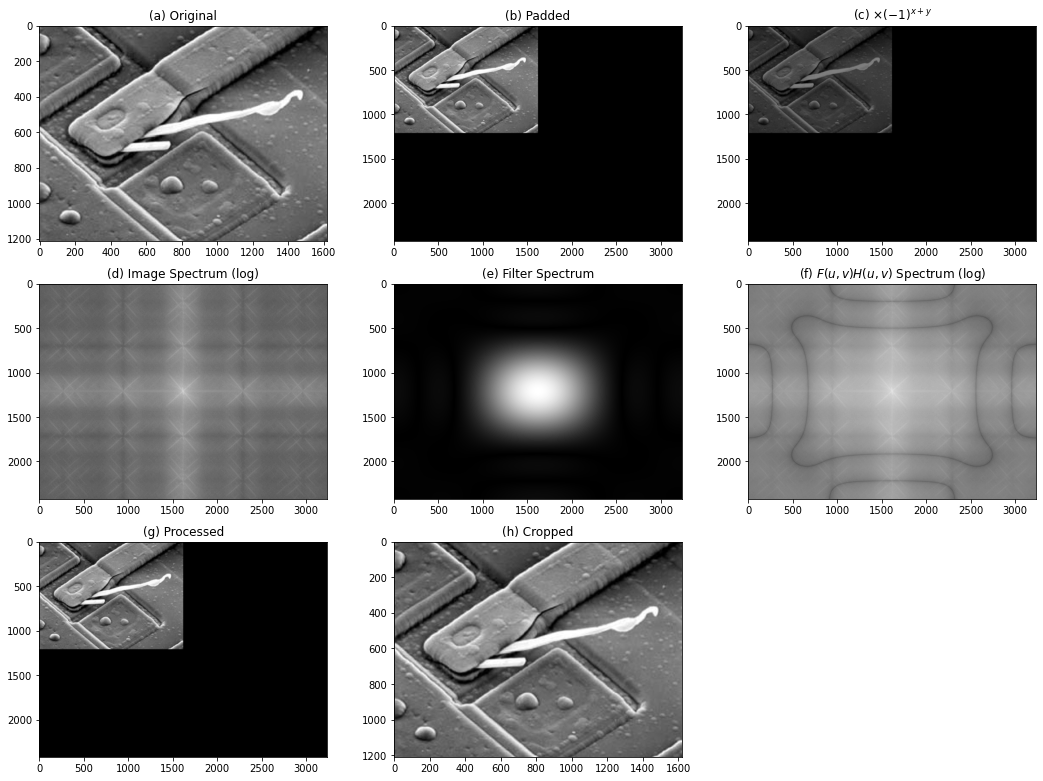

In [99]:
import cv2 as cv
from scipy.fft import fftn, ifftn                                 # emphasize again that the `fft` is not hard to implement. you may check the last tutorial
import matplotlib.pyplot as plt

img_path = 'images/circuit.png'

img = cv.imread(img_path, 0)

M, N = img.shape                                                  # Step 1.1 Get the shape of the image

P = 2 * M
Q = 2 * N                                                         # Step 1.* Decide the size of padding

# >>>>>>>>>>>>>>>>> construct the filter <<<<<<<<<<<<<<<<<
lp_filter = np.array([[2, 4,  5,  4,  2],
                      [4, 9,  12, 9,  4],
                      [5, 12, 15, 12, 5],
                      [4, 9,  12, 9,  4],
                      [2, 4,  5,  4,  2]], dtype=float)            # a symmetric filter, with larger value in the middle
lp_filter /= np.sum(lp_filter)                                     # normalize the filter (to ensure that the summation is 1)

C, D = lp_filter.shape                                             # Step 1.2 Get the shape of the filter

lp_filter_p = np.zeros((P,Q), dtype=float)
lp_filter_p[:C, :D] = lp_filter[:C, :D]                            # Step 2.2 Pad the filter              

X = np.arange(P)[:,None]
Y = np.arange(Q)
shift_mask = (-1) ** (X + Y)                                       # Step 3.* Construct the shifting mask

# here we don't use `fftshift` in the frequency domain, but multiple (-1)^(x+y) in the spatial domain
lp_filter_shift = lp_filter_p * shift_mask                         # Step 3.2 Shift the filter

# >>>>>>>>>>> finish constructing the filter <<<<<<<<<<<<<

img_p = np.zeros((P,Q)) 
img_p[:M, :N] = img[:M, :N]                                        # Step 2.1 Pad the image 

img_shift = img_p * shift_mask
img_shift_to_show = np.where(img_shift > 0, img_shift, 0)          # just for plotting (negative number could influence the visual result -> set as 0)

fimg = fftn(img_shift)                                             # Step 4.1 Fourier Transform over the image
flp_filter_shift = fftn(lp_filter_shift)                           # Step 4.2 Fourier Transform over the filter

    #    >>>>>>>   omit step 5 here   <<<<<<

cimg = fimg * flp_filter_shift                                     # Step 6   Form the product of the image and the filter at the frequency domain
iimg = np.real(ifftn(cimg)) * shift_mask                           # Step 7   Inverse Fourier Transform with Shifting
iimg_crop = iimg[:M,:N]                                            # Step 8   crop the image

fimg_to_show = np.log(np.abs(fimg) + 1e-8)                         # just for plotting; + 10^(-8) to avoid log(0)
flp_filter_shift_to_show = np.abs(flp_filter_shift)                # just for plotting (no log here)
cimg_to_show = np.log(np.abs(cimg) + 1e-8)                         # just for plotting; + 10^(-8) to avoid log(0)

# >>>>>>>>>>>>>>>>> plot the results <<<<<<<<<<<<<<<<<<<
L = max(M, N)
L0 = 18
W = L0 * N / L
H = L0 * M / L
plt.figure(figsize=(W,H))
plt.subplot(331); plt.imshow(img, 'gray'); plt.title('(a) Original')      # Semicolons (i.e. ";") can delimit statements if you wish to put multiple statements on the same line
plt.subplot(332); plt.imshow(img_p, 'gray'); plt.title('(b) Padded')    
plt.subplot(333); plt.imshow(img_shift_to_show, 'gray'); plt.title(r'(c) $\times (-1)^{x+y}$')
plt.subplot(334); plt.imshow(fimg_to_show, 'gray'); plt.title('(d) Image Spectrum (log)')
plt.subplot(335); plt.imshow(flp_filter_shift_to_show, 'gray'); plt.title('(e) Filter Spectrum')
plt.subplot(336); plt.imshow(cimg_to_show, 'gray'); plt.title(r'(f) $F(u,v)H(u,v)$ Spectrum (log)')
plt.subplot(337); plt.imshow(iimg, 'gray'); plt.title('(g) Processed')
plt.subplot(338); plt.imshow(iimg_crop, 'gray'); plt.title('(h) Cropped')
plt.show()
# >>>>>>>>>>>> finish plotting the result <<<<<<<<<<<<<<

As mentioned above, real part is selected for the handled image in order to ignore parasitic complex components resulting from computational inaccuracies, since the fact that $f$ and $h$ are real ensures that $f \star h$ is real. Here we may check the computational inaccuracies by printing (some proportion of) the imaginary part of the handled image.

In [100]:
iimg_tmp = ifftn(cimg)
I = np.imag(iimg_tmp)
print(I[:3,:3])
print(np.all(I==0))

[[-8.21565038e-15  5.78356807e-15 -7.08461068e-15]
 [ 2.66453526e-15 -7.88952237e-15  1.82839854e-14]
 [ 5.32907052e-15 -4.48772963e-15  1.29063427e-15]]
False


When we are calculating $(-1)^{x+y}$, we utilize the broadcasting feature of Numpy. Check the following example for why it works. You may further speed it up considering that its actually oscillating between 1 and -1 along the columns and along the rows.

In [101]:
A = 5
B = 5

X1 = np.arange(A)[:,None]
Y1 = np.arange(B)
K1 = (-1) ** (X1+Y1)

X2 = np.tile(np.arange(A), (B, 1)).T        # "tile" means to repeat in rows and columns according to the "reps" parameter. "T" means to take the transpose here
Y2 = np.tile(np.arange(B), (A, 1))
K2 = np.full((A,B),-1) ** (X2+Y2)

K3 = np.array([[(-1)**(x+y) for x in range(B)] for y in range(A)])

In [102]:
print('X1:\n', X1)
print('Y1:', Y1)
print('K1:\n', K1)

X1:
 [[0]
 [1]
 [2]
 [3]
 [4]]
Y1: [0 1 2 3 4]
K1:
 [[ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]]


In [103]:
print('X2:\n', X2)
print('Y2:\n', Y2)
print('K2:\n', K2)

X2:
 [[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
Y2:
 [[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]
K2:
 [[ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]]


In [104]:
print('K3:\n', K3)
print(np.all(K1==K2))
print(np.all(K2==K3))

K3:
 [[ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]]
True
True


Also note that to times $(-1)^{x+y}$ in the spatial domain is equivalent to shift $(P/2, Q/2)$ in the frequency domain. We may test that below, and for convenience we utilize the `fftshift` we mentioned in the last tutorial (we can see that there is still a little gap, so we use `np.allclose` for checking the equality):

In [105]:
from scipy.fft import fftshift

img_test = fftshift(fftn(img_p))
print(img_test[:3,:3])
print(fimg[:3,:3])
print(np.allclose(img_test, fimg))

[[ 635.        +5.68434189e-14j  442.40147991-3.66341557e+02j
   194.32159715-3.61764124e+02j]
 [ 146.71067985-5.61874137e+02j -136.08979631-2.98740317e+02j
  -141.11789042-2.50997205e+02j]
 [-251.09402465+1.67853553e+02j  114.53574607+6.23546691e+01j
   -50.83364226+2.03225431e+02j]]
[[ 635.          -0.j          442.40147991-366.34155662j
   194.32159715-361.76412423j]
 [ 146.71067985-561.87413669j -136.08979631-298.74031725j
  -141.11789042-250.9972046j ]
 [-251.09402465+167.85355339j  114.53574607 +62.35466906j
   -50.83364226+203.22543106j]]
True


We can see in the example above that the image is not "blurred" enough after our processing. This is because that the $\sigma$ we adopt here is not large enough -- this is somewhat a gaussian kernel, and with the knowledge shown in Page 94 of lecture 2's slides, we can see that larger $\sigma$ could lead to greater effect of "blurring" or "smoothing". Also, by checking Page 76 of lecture 3's slides, we can see that the functions of $h(u)$ and $H(u)$ behave reciprocally in the spatial domain and the frequency domain, which means that larger $\sigma$ in the spatial domain filter will make the frequency domain filter narrower. In the example shown in Page 75 of lecture 3, we can see from the spectrum of the filter that it's narrower than our example. Hence, we may wrap the above codes into a function and pass a spatial gaussian filter with larger sigma (e.g. 10).

Below we define a spatial gaussian square kernel generator where the size $l=5\sigma$ by default, as suggested in page 92 of lecture 2.

In [162]:
def gaussian_kernel(sig: float = 1.0, A: float = 1.0, l: int = None)->np.ndarray:
    if l is None and sig is not None:
        l = int(np.ceil(sig)) * 5                   # 5 * sigma in size by default
    u = np.linspace(-(l - 1) / 2, (l - 1) / 2, l)   # a symmetric u sequence with zero-center (take average for the even case)
    gauss = A * np.exp(-0.5 * u ** 2 / sig ** 2)    # H(u) = A e ^ {- 1/2 * u^2 / sigma^2}
    kernel = np.outer(gauss, gauss)                 # use outer product to extend from 1-dim to 2-dim. If we times A here, it will corresponds to A^2
    return kernel / np.sum(kernel)                  # normalize the kernel to ensure that the summation equals 1

print(gaussian_kernel())  # default kernel with amplitude equals 1 and sigma equals 1. We can see that it's symmetric

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


From the result below we can see the processed image is quite "blurred". Here the filter is "low-pass", i.e. it allows the signal with low frequency to pass. After shifting, we have frequency near zero around the center, and we call these part are of "low-frequency" as their magnitude of frequency are small, and for parts far from the center, we say they are of "high-frequency". The gaussian filter in the frequency domain has higher value to emphasize the central part when doing the multiplication, while deemphasize those part away from the center since its value is small. Hence, it exactly emphasize the high-frequency part and deemphasize the low frequency part.

We've mentioned in the last tutorial that in the fourier series, those non-smooth or non-continuous parts required very high frequency to represent when constructing the fourier coefficient, and that is somewhat similar as we consider the fourier transform as the limiting case of the fourier coefficient. Hence, when we emphasize those part of low frequency and deemphasize those of high frequency, this would increase the smoothness.

Here we introduce the renewed way of padding, where we can pad around a filter when required.

In [185]:
from typing import Union, Tuple

def pad(P: int, Q: int, source: np.ndarray, filter_pad_around: bool = False, strict_mode: bool = False)->Union[np.ndarray, Tuple[np.ndarray, int, int]]:
    A, B = source.shape
    result = np.zeros((P,Q), source.dtype)
    if filter_pad_around:
        if not (P % 2 == A % 2 and Q % 2 == B % 2) and strict_mode:
            raise ValueError('Not allowed for padding around!')
        bm = (P-A) / 2
        bml = int(np.floor(bm))
        bmr = int(np.ceil(bm))
        bn = (Q-B) / 2
        bnl = int(np.floor(bn))
        bnr = int(np.ceil(bn))
        result[bml:P-bmr, bnl:Q-bnr] = source[:A, :B]
    else:
        result[:A, :B] = source[:A, :B]
    if filter_pad_around:
        return result, bml, bnl
    else:
        return result

In the wrapped function below, we consider the parity and do the "roll-back" operation when the filter is padded around. The reason we need to roll back can be derived using the translation properties and the convolution theory of fourier transform:

Translation Property:

$$
f(x - x_s, y - y_s) \Leftrightarrow  F(u, v) e^{-j 2 \pi (u x_s / M + v y_s / N)}
$$

Convolution Theory:

$$
f(x,y) \star h(x,y) \Leftrightarrow F(u, v) H(u, v)
$$

As to pad the filter $h$ around is equivalent to shift the filter padded in the usual way, with the convolution theory, we have:

$$
f(x,y) \star h(x - x_s,y - y_s) \Leftrightarrow F(u, v) (H(u, v) e^{-j 2 \pi (u x_s / M + v y_s / N)}) \\
$$

with the equation $F(u, v) (H(u, v) e^{-j 2 \pi (u x_s / M + v y_s / N)}) = (F(u, v)e^{-j 2 \pi (u x_s / M + v y_s / N)})  H(u, v)$ we have:

$$
f(x - x_s,y - y_s) \star h(x,y) \Leftrightarrow (F(u, v)e^{-j 2 \pi (u x_s / M + v y_s / N)})  H(u, v) \\
$$

So we know that int the final result image would be rolled if we pad the filter around, and we shall roll it back.

In [209]:
def show_process_procedure(img_path: str, filter_arr: np.ndarray,
                           tight_padding: bool = False,
                           filter_pad_around: bool = False,
                           force_filter_real_drop: bool = False,
                           force_filter_imag_drop: bool = False)->None:
    if tight_padding and filter_pad_around:
        raise ValueError('Not yet support for both of `tight_padding` and `filter_pad_around` to be True!')

    if force_filter_real_drop and force_filter_imag_drop:
        raise ValueError('Can not force to drop both part of the filter!')
    
    img = cv.imread(img_path, 0)

    M, N = img.shape                                                   # Step 1.1 Get the shape of the image
    C, D = filter_arr.shape                                            # Step 1.2 Get the shape of the filter

    P, Q = (M + C - 1, N + D - 1) if tight_padding else (2 * M, 2 * N) # Step 1.* Decide the size of padding

    res = pad(P, Q, filter_arr, filter_pad_around)                     # Step 2.2 Pad the filter

    if filter_pad_around:
       filter_arr_p, xs, ys = res
    else:
       filter_arr_p = res

    X = np.arange(P)[:,None]
    Y = np.arange(Q)
    shift_mask = (-1) ** (X + Y)                                       # Step 3.* Construct the shifting mask

    # here we don't use `fftshift` in the frequency domain, but multiple (-1)^(x+y) in the spatial domain
    filter_arr_shift = filter_arr_p * shift_mask                       # Step 3.2 Shift the filter

    img_p = pad(P, Q, img)                          # Step 2.1 Pad the image                                    

    img_shift = img_p * shift_mask
    img_shift_to_show = np.where(img_shift > 0, img_shift, 0)          # just for plotting (negative number could influence the visual result -> set as 0)

    fimg = fftn(img_shift)                                             # Step 4.1 Fourier Transform over the image
    ffilter_arr_shift = fftn(filter_arr_shift)                         # Step 4.2 Fourier Transform over the filter

    even_odd = check_even_odd_2d(filter_arr_shift)                     # Step 5   Correction base on the odd property of h
    is_even = even_odd == 0 or even_odd == 2
    is_odd = even_odd == 0 or even_odd == 1
    
    if is_even:
        print('Even filter detected!')
    if is_even or force_filter_imag_drop:
        print('Remove the imaginary part!')
        ffilter_arr_shift = np.real(ffilter_arr_shift)
    if is_odd:
        print('Odd filter detected!')
    if is_odd or force_filter_real_drop:
        print('Remove the real part!')
        ffilter_arr_shift = 1j * np.imag(ffilter_arr_shift)

    cimg = fimg * ffilter_arr_shift                                    # Step 6   Form the product of the image and the filter at the frequency domain
    iimg = np.real(ifftn(cimg)) * shift_mask                           # Step 7   Inverse Fourier Transform with Shifting
    
    if filter_pad_around:                                              # step 8   roll the image if necessary
        iimg_old = iimg
        iimg_roll = np.roll(iimg, shift=(-xs, -ys), axis=(0, 1))
        iimg = iimg_roll

    iimg_crop = iimg[:M,:N]                                            # Step 9   crop the image

    fimg_to_show = np.log(np.abs(fimg) + 1e-8)                         # just for plotting; + 10^(-8) to avoid log(0)
    ffilter_arr_shift_to_show = np.abs(ffilter_arr_shift)              # just for plotting (no log here)
    cimg_to_show = np.log(np.abs(cimg) + 1e-8)                         # just for plotting; + 10^(-8) to avoid log(0)

    # >>>>>>>>>>>>>>>>> plot the results <<<<<<<<<<<<<<<<<<<
    L = max(M, N)
    L0 = 18
    W = L0 * N / L
    H = L0 * M / L
    plt.figure(figsize=(W,H))
    plt.subplot(331); plt.imshow(img, 'gray'); plt.title('(a) Original')      # Semicolons (i.e. ";") can delimit statements if you wish to put multiple statements on the same line
    plt.subplot(332); plt.imshow(img_p, 'gray'); plt.title('(b) Padded')    
    plt.subplot(333); plt.imshow(img_shift_to_show, 'gray'); plt.title(r'(c) $\times (-1)^{x+y}$')
    plt.subplot(334); plt.imshow(fimg_to_show, 'gray'); plt.title('(d) Image Spectrum (log)')
    plt.subplot(335); plt.imshow(ffilter_arr_shift_to_show, 'gray'); plt.title('(e) Filter Spectrum')
    plt.subplot(336); plt.imshow(cimg_to_show, 'gray'); plt.title(r'(f) $F(u,v)H(u,v)$ Spectrum (log)')
    if filter_pad_around:
        plt.subplot(337); plt.imshow(iimg_old, 'gray'); plt.title('(g) Processed')
        plt.subplot(338); plt.imshow(iimg_roll, 'gray'); plt.title('(h) Rolled Back')
        plt.subplot(339); plt.imshow(iimg_crop, 'gray'); plt.title('(i) Cropped')
    else:
        plt.subplot(337); plt.imshow(iimg, 'gray'); plt.title('(g) Processed')
        plt.subplot(338); plt.imshow(iimg_crop, 'gray'); plt.title('(h) Cropped')
    plt.show()
    # >>>>>>>>>>>> finish plotting the result <<<<<<<<<<<<<<

Now we check whether the gaussian kernel with larger sigma works.

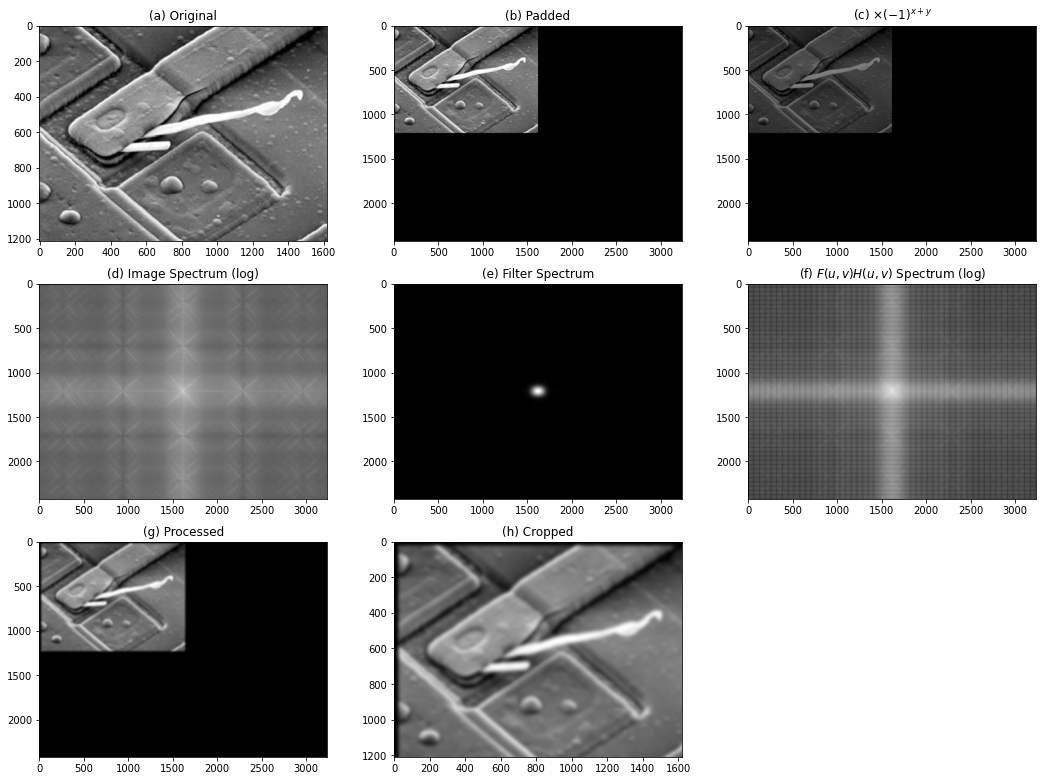

In [187]:
img_path = 'images/circuit.png'
filter_arr = gaussian_kernel(10)
show_process_procedure(img_path, filter_arr)

We can also pad it using $P = M + C - 1$ and $Q = N + D - 1$

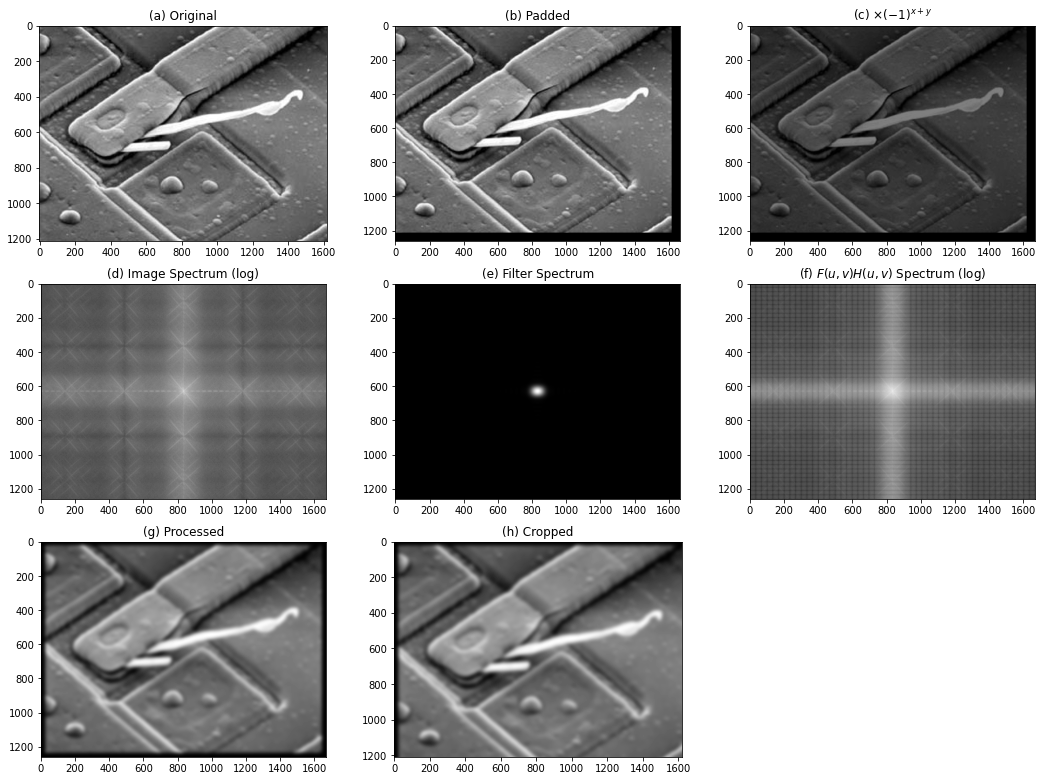

In [188]:
img_path = 'images/circuit.png'
filter_arr = gaussian_kernel(10)
show_process_procedure(img_path, filter_arr, tight_padding=True)

If we don't consider the fact that the padded filter $h_p$ didn't pass the even-checking, but throw the imaginary part of the filter $H_p$ forcedly in the frequency domain, we shall see some error:

Remove the imaginary part!


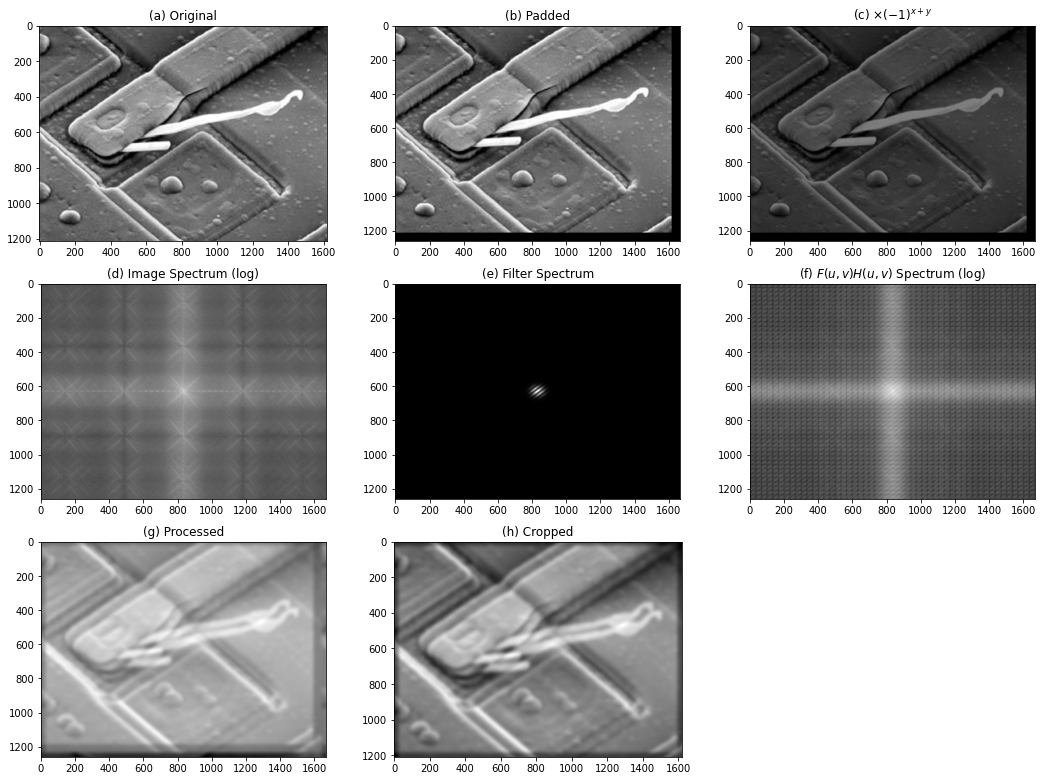

In [194]:
img_path = 'images/circuit.png'
filter_arr = gaussian_kernel(10)
show_process_procedure(img_path, filter_arr, tight_padding=True, force_filter_imag_drop=True)

If the $h_p$ did pass the even or odd checking, we can throw those part considered to be zero safely:

Even filter detected!
Remove the imaginary part!


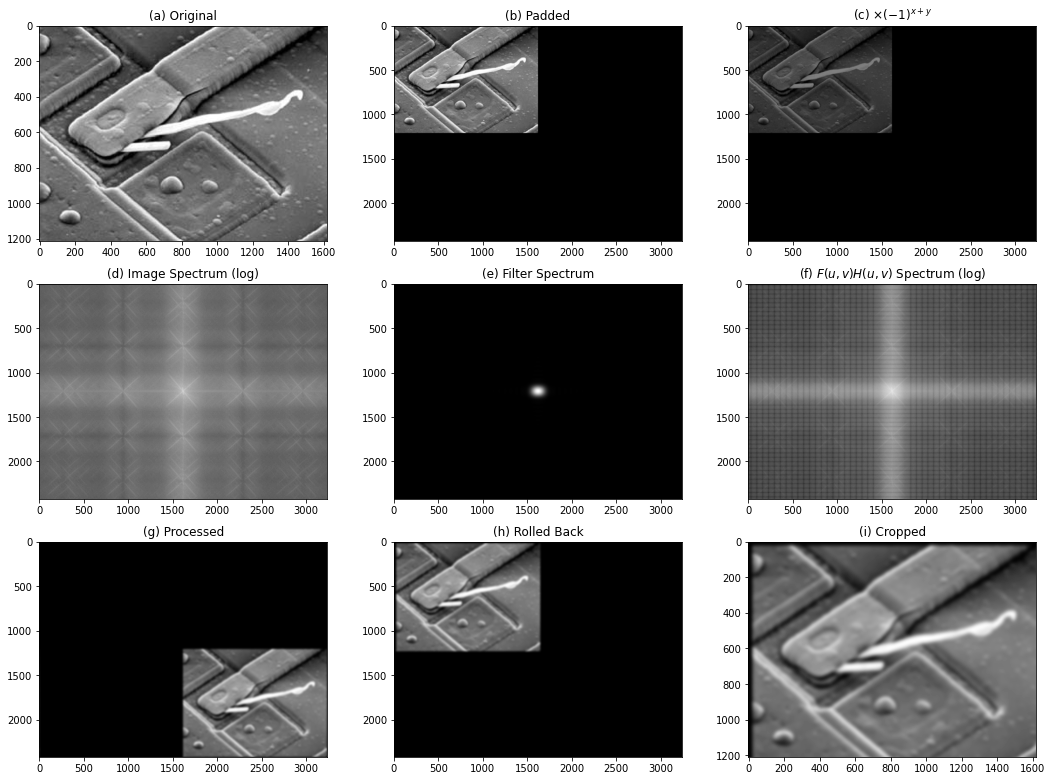

In [197]:
img_path = 'images/circuit.png'
filter_arr = add_leading_zeros(gaussian_kernel(10, l=49))
show_process_procedure(img_path, filter_arr, filter_pad_around=True)

## 2. Consider the High Pass Filter

With the codes implement above, we can easily reproduce the effect of high pass filter. One example is the sobel filter in the spatial domain. Note that we show the spectrum of the filter in the frequency domain, and those negative values will become positive.

Odd filter detected!
Remove the real part!


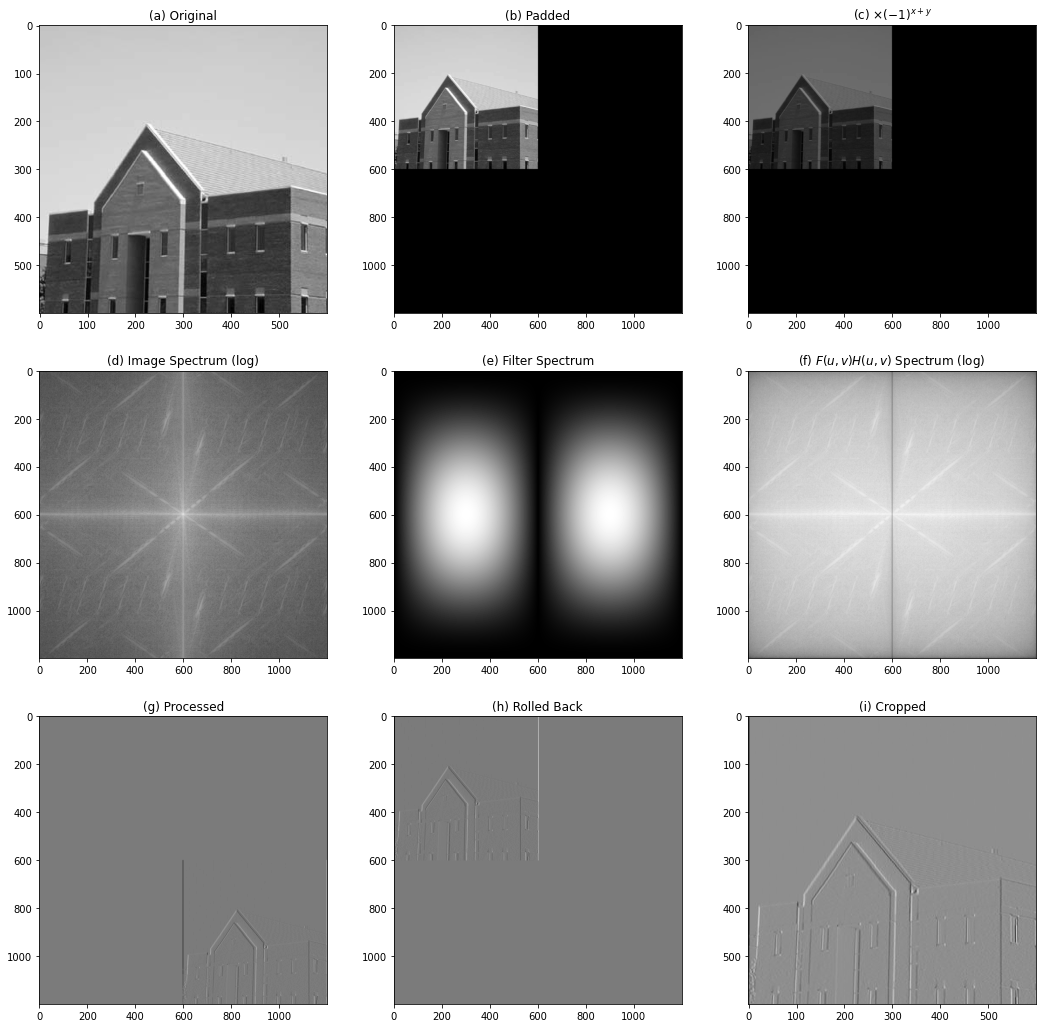

In [210]:
img_path = 'images/house.png'
'''
The Sobel Filter

                    [-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]

here is not odd as it's not leaded by 0. We can pad it to a 4 * 4 filter with a leading row/column of zero, as mentioned in the textbook, Page 271(but in edition 4, not 3)
'''
filter_arr = np.array([[0,  0, 0, 0],
                       [0, -1, 0, 1],
                       [0, -2, 0, 2],
                       [0, -1, 0, 1]])      # i.e. the `k2p` mentioned above

show_process_procedure(img_path, filter_arr, filter_pad_around=True)

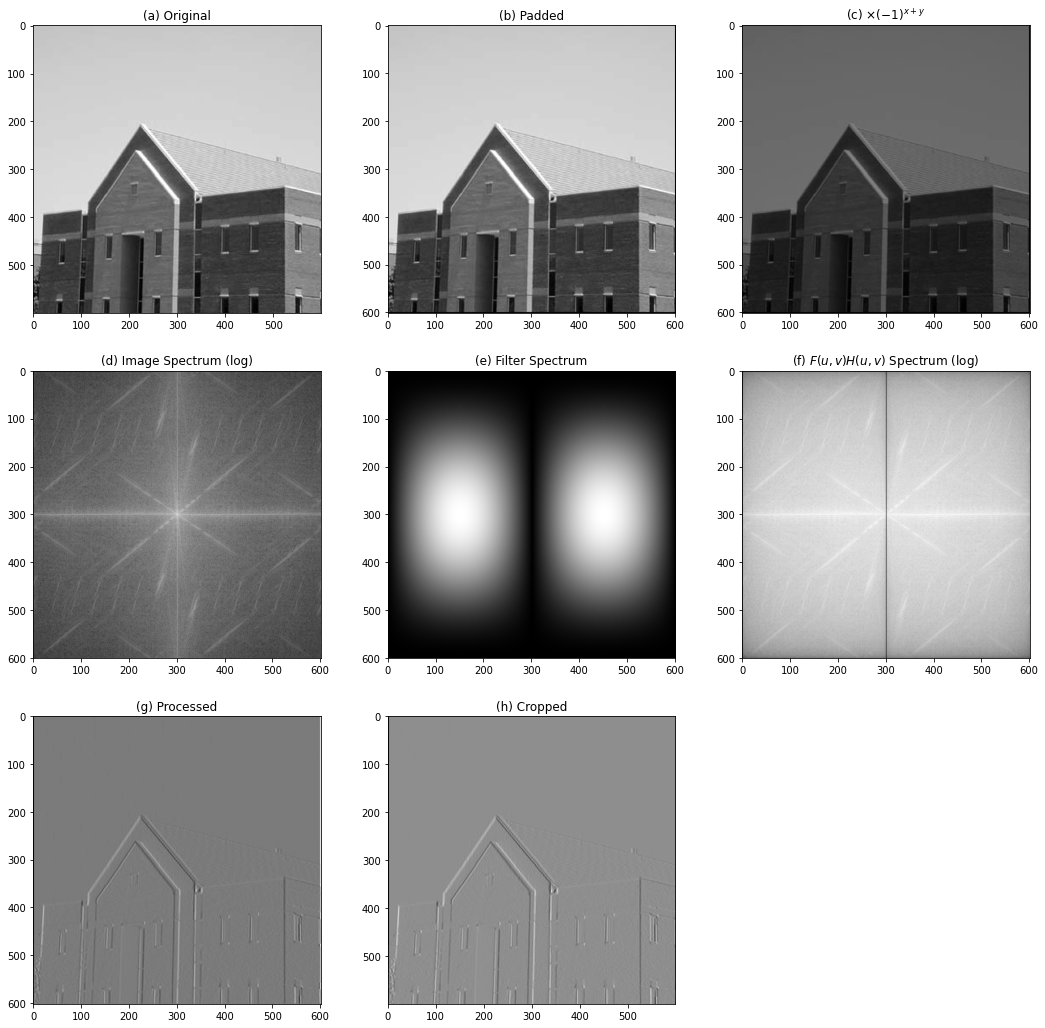

In [212]:
show_process_procedure(img_path, filter_arr, tight_padding=True)

The other example is the subtraction of two gaussian kernel in the spatial domain. Note that we interpret it as a high-pass filter as in the spatial domain, it has positive values and negative values which sums up to be zero (a thin and high gaussian subtracted by a wide and low one, lead to positive values around the center and negative values elsewhere). While in the frequency domain, it's the subtraction between a wide and high gaussian and a thin and low gaussian. You may check the spectrum for the shape since the value is always positive. In the frequency domain we explain in a frequency perspective: the absolute value of the filter at the center, i.e. the low frequency area is small, so it deemphasize the low frequency, while in the high frequency part, the absolute value is large so it emphasize those high frequency part. 

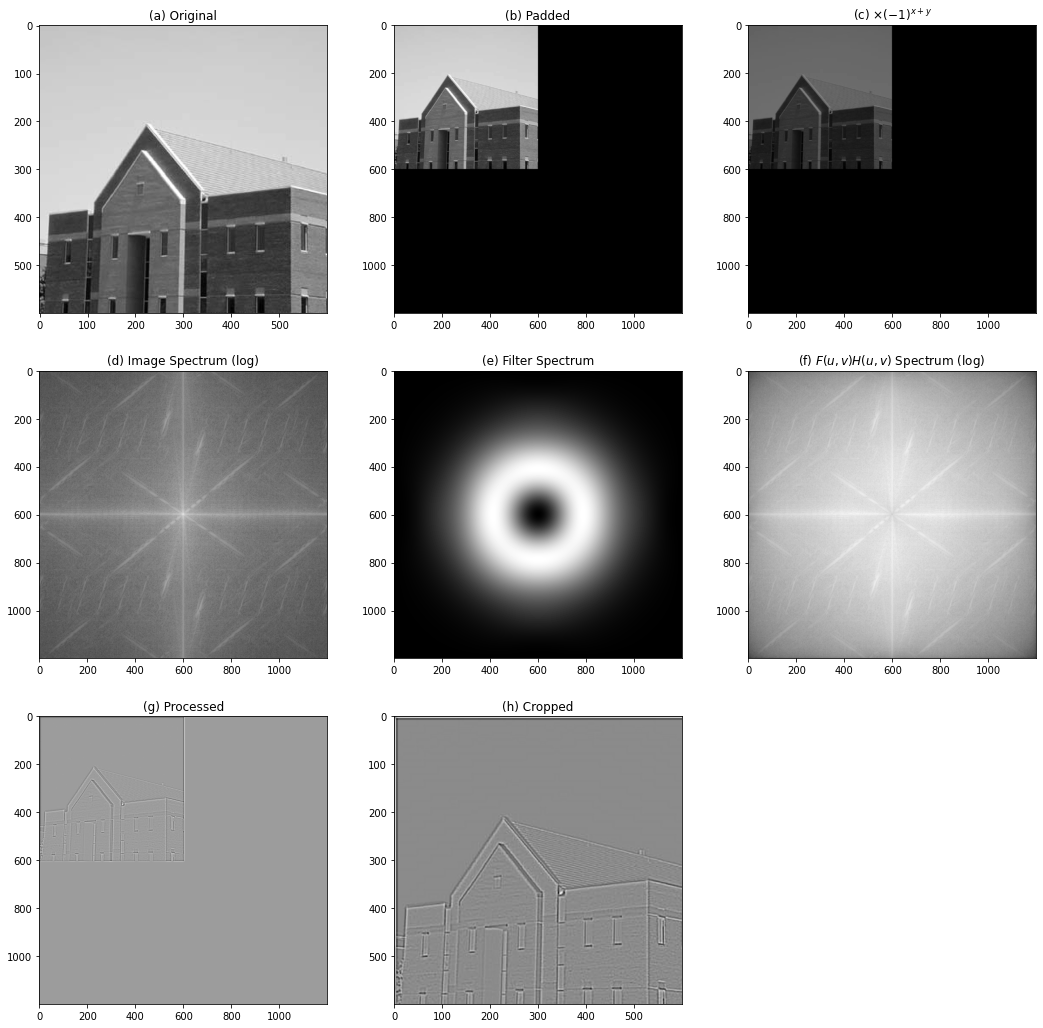

In [213]:
filter_arr = gaussian_kernel(2, 2, 10) - gaussian_kernel(1, 1, 10)
show_process_procedure(img_path, filter_arr)

## 3. Some Practice

## 3.1 Practice One
Use the former codes we implement to show the spectrum of [45degree.png](images/45degree.png), [135degree.png](images/135degree.png), [center.png](images/center.png), [wide.png](images/wide.png), [long.png](images/long.png), [circuit.png](images/circuit.png), and [circuit_damaged_part.png](images/circuit_damaged_part.png) in the [images/](images/) directory. Then answer these two questions "why is the spectrum of the circuit at almost ±45 degree stronger than the spectrum at other directions" and "why there is a vertical trail of white dots on the spectrum slightly tilted to the left" by analyzing the output.

## 3.3 Practice Two
Imitate the codes TA Wei, Jun implemented in the former tutorial sessions about convolution, and compare the results using the sample images like [circuit.png](images/circuit.png) and the filter like gaussian filter.